# ETH price prediction

In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data = pd.read_csv('ETH-USD.csv')

In [4]:
data.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-01,129.630661,132.835358,129.198288,130.802002,130.802002,7935230330
1,2020-01-02,130.820038,130.820038,126.954910,127.410179,127.410179,8032709256
2,2020-01-03,127.411263,134.554016,126.490021,134.171707,134.171707,10476845358
3,2020-01-04,134.168518,136.052719,133.040558,135.069366,135.069366,7430904515
4,2020-01-05,135.072098,139.410202,135.045624,136.276779,136.276779,7526675353


### Adding features

In [5]:
year = []
month=[]
day=[]
for i in data['Date'].values:
    x = i.split('-')
    year.append(int(x[0]))
    month.append(int(x[1]))
    day.append(int(x[2]))
data['Year'] = year
data['Month'] = month
data['Day'] = day

In [6]:
data.sample(5)

,Date,Open,High,Low,Close,Adj Close,Volume,Year,Month,Day
270,2020-09-27,354.959900,361.984406,349.834076,357.438507,357.438507,13598126926,2020,9,27
375,2021-01-10,1280.871094,1347.926147,1194.715576,1262.246704,1262.246704,40616938053,2021,1,10
1072,2022-12-08,1232.451782,1286.229736,1226.358521,1281.116333,1281.116333,6227269815,2022,12,8
1151,2023-02-25,1608.658325,1608.865112,1567.631714,1594.914917,1594.914917,5657686235,2023,2,25
1215,2023-04-30,1908.741333,1938.417969,1876.924316,1876.924316,1876.924316,6539641957,2023,4,30


In [7]:
data['Date']=pd.to_datetime(data['Date'])

In [8]:
# prev_score give us the difference between the highest price and the lowest price
data['Prev_close'] = data['Close'].shift(1)
data.dropna(axis=0,inplace=True)
# delta_hl give us the difference between the highest and the actual close
data['delta_hl'] = data['High'] - data['Low']

In [9]:
train = data[data['Date'] <= pd.datetime(2022,12,31,23,59)]
test = data[data['Date'] >= pd.datetime(2022,12,31,23,59)]

C:\Users\DELL\AppData\Local\Temp\ipykernel_6820\1666691955.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  train = data[data['Date'] <= pd.datetime(2022,12,31,23,59)]
C:\Users\DELL\AppData\Local\Temp\ipykernel_6820\1666691955.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  test = data[data['Date'] >= pd.datetime(2022,12,31,23,59)]


### Visualisation

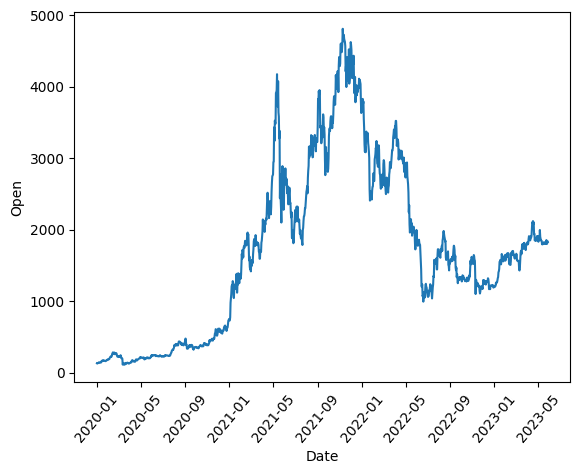

In [10]:
sns.lineplot(data,x='Date',y='Open')
plt.xticks(rotation = 50)
plt.show()      

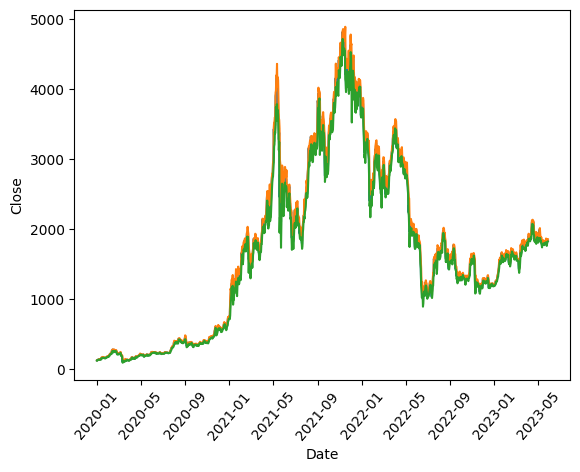

In [11]:
sns.lineplot(data,x='Date',y='Close')
sns.lineplot(data,x='Date',y='High')
sns.lineplot(data,x='Date',y='Low')
plt.xticks(rotation = 50)
plt.show()      

In [12]:
true_test = test['Close']

In [13]:
train.drop('Date',axis=1,inplace=True)
test.drop('Date',axis=1,inplace=True)

C:\Users\DELL\AppData\Local\Temp\ipykernel_6820\565370736.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.drop('Date',axis=1,inplace=True)
C:\Users\DELL\AppData\Local\Temp\ipykernel_6820\565370736.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop('Date',axis=1,inplace=True)


### Model

In [14]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn import metrics

In [15]:
y=train['Close']
x=train.drop('Close',axis=1,inplace=False)
train_X, test_X, train_y, test_y = train_test_split(x, y,test_size = 0.3, random_state = 40)
xgb_r = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators = 10, seed = 123)
xgb_r.fit(train_X, train_y)
pred = xgb_r.predict(test_X)
rmse = np.sqrt(MSE(test_y, pred))
print("RMSE : % f" %(rmse))
print("R squared: ", metrics.r2_score(test_y,pred))

RMSE :  73.809436
R squared:  0.9967817639797237


In [16]:
tst = test.drop('Close',axis=1,inplace=False)
tst=tst.to_numpy()

In [17]:
pred=xgb_r.predict(tst)
rmse = np.sqrt(MSE(true_test, pred))
print("RMSE : % f" %(rmse))
print("R squared: ", metrics.r2_score(true_test,pred)) 

RMSE :  61.613814
R squared:  0.8948556266597353


### Optimisation

In [18]:
def accuracy(k):    
    train_X, test_X, train_y, test_y = train_test_split(x, y,test_size = 0.3, random_state = k)
    xgb_r = xgb.XGBRegressor(objective ='reg:tweedie',n_estimators = 40, seed = 0)
    xgb_r.fit(train_X, train_y)
    pred = xgb_r.predict(test_X)
    rmse = np.sqrt(MSE(test_y, pred))
    return rmse
def best_rd(x):
    d=[]
    for i in range(0,x+1):
        d.append(accuracy(i))
    return d
c =best_rd(200)
m=c.index(min(c))
m

44

In [19]:
def accuracy(k):    
    train_X, test_X, train_y, test_y = train_test_split(x, y,test_size = 0.3, random_state = 44)
    xgb_r = xgb.XGBRegressor(objective ='reg:tweedie',n_estimators = k, seed = 0)
    xgb_r.fit(train_X, train_y)
    pred = xgb_r.predict(test_X)
    rmse = np.sqrt(MSE(test_y, pred))
    return rmse
def best_rd(x):
    d=[]
    for i in range(0,x+1):
        d.append(accuracy(i))
    return d
c =best_rd(100)
m=c.index(min(c))
m

69

### Score and Evaluation

In [21]:
y=train['Close']
x=train.drop('Close',axis=1,inplace=False)
train_X, test_X, train_y, test_y = train_test_split(x, y,test_size = 0.3, random_state = 44)
xgb_r = xgb.XGBRegressor(objective ='reg:tweedie',n_estimators = 69, seed = 0)
xgb_r.fit(train_X, train_y)
pred = xgb_r.predict(test_X)
rmse = np.sqrt(MSE(test_y, pred))
print("RMSE : % f" %(rmse))
print("R squared: ", metrics.r2_score(test_y,pred))

RMSE :  9.103153
R squared:  0.9999459872469382


In [22]:
pred=xgb_r.predict(tst)
rmse = np.sqrt(MSE(true_test, pred))
print("RMSE : % f" %(rmse))
print("R squared: ", metrics.r2_score(true_test,pred)) 

RMSE :  7.078898
R squared:  0.9986120902890627


In [23]:
comparaison = pd.DataFrame()
x = true_test.values

In [24]:
comparaison['Predictions'] = pred
comparaison['True_test'] = x

In [25]:
comparaison

,Predictions,True_test
0,1195.004272,1200.964844
1,1216.155396,1214.656616
2,1215.969849,1214.778809
3,1269.114014,1256.526611
4,1233.517700,1250.438599
...,...,...
143,1804.051636,1800.099976
144,1797.019165,1805.953735
145,1829.772949,1828.689697
146,1827.976440,1831.118286


<Axes: xlabel='Predictions', ylabel='True_test'>

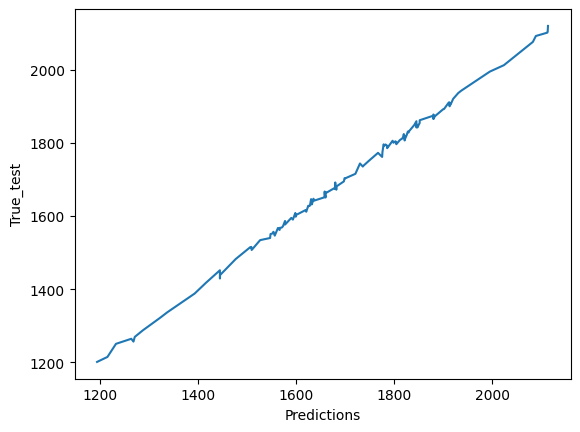

In [26]:
sns.lineplot(comparaison,x='Predictions',y='True_test')

In [27]:
import pickle
with open('eth_regressor','wb') as f:
    pickle.dump(xgb_r,f)